# Loops

This section tackles the Python loop issue. The task is rather simple: a function shall be written that draws a certain "large" number of random numbers and returns the average of the values. The execution time is of interest, which can be estimated by the magic functions %time and %timeit .

## Python

Let's get started "slowly" - forgive the pun. In pure Python, such a function might look like `average_py()`:

In [15]:
import random

In [16]:
def average_py(n):
    s = 0
    for i in range(n):
        s += random.random()
    return s / n

In [17]:
n = 10000000

In [4]:
%time average_py(n)

CPU times: user 629 ms, sys: 1.18 ms, total: 630 ms
Wall time: 627 ms


0.4998908812311153

In [5]:
%timeit average_py(n)

623 ms ± 4.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%time sum([random.random() for _ in range(n)]) / n

CPU times: user 714 ms, sys: 63.9 ms, total: 778 ms
Wall time: 776 ms


0.5000201935073094

This sets the benchmark for the other approaches to follow.

## NumPy

The strength of `NumPy` lies in its vectorization capabilities. Formally, loops vanish on the Python level; the looping takes place one level deeper based on optimized and compiled routines provided by `NumPy`. The function
`average_np()` makes use of this approach:

In [18]:
import numpy as np

In [8]:
def average_np(n):
    s = np.random.random(n)
    return s.mean()

In [9]:
%time average_np(n)

CPU times: user 54.7 ms, sys: 0 ns, total: 54.7 ms
Wall time: 54.3 ms


0.5001373693664576

In [10]:
%timeit average_np(n)

52.6 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
s = np.random.random(n)
s.nbytes

80000000

The speedup is considerable, reaching almost a factor of 10 or an order of magnitude. However, the price that must be paid is significantly higher memory usage. This is due to the fact that `NumPy` attains speed by preallocating data that can be processed in the compiled layer. As a consequence, there is no way, given this approach, to work with "streamed" data. This increased memory usage might even be prohibitively large depending on the algorithm or problem at hand.

## Numba

`Numba` is a package that allows the *dynamic compiling* of pure Python code by the use of LLVM. The application in a simple case, like the one at hand, is surprisingly straightforward and the dynamically compiled function
`average_nb()` can be called directly from Python:

In [19]:
import numba

In [13]:
# This creates the Numba function.
average_nb = numba.jit(average_py)

In [14]:
# The compiling happens during runtime, leading to some overhead.
%time average_nb(n)

CPU times: user 118 ms, sys: 4.26 ms, total: 122 ms
Wall time: 159 ms


0.4999675029998574

In [15]:
# From the second execution (with the same input data types), the execution is faster.
%time average_nb(n)

CPU times: user 34.5 ms, sys: 85 µs, total: 34.6 ms
Wall time: 34.5 ms


0.49995640221485116

In [16]:
%timeit average_nb(n)

32.8 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The combination of pure Python with `Numba` beats the `NumPy` version and preserves the memory efficiency of the original loop-based implementation. It is also obvious that the application of `Numba` in such simple cases comes with hardly any programming overhead.

## Cython

`Cython` allows one to *statically compile* Python code. However, the application is not as simple as with `Numba` since the code generally needs to be changed to see significant speed improvements. To begin with, consider the `Cython` function `average_cy1()`, which introduces static type declarations for the used variables:

In [20]:
%load_ext Cython

In [18]:
%%cython -a
# Imports the random module within the Cython context.
import random
# Adds static type declarations for the variables n , i , and s .
def average_cy1(int n):
    cdef int i
    cdef float s = 0
    for i in range(n):
        s += random.random()
    return s / n

In [19]:
%time average_cy1(n)

CPU times: user 356 ms, sys: 0 ns, total: 356 ms
Wall time: 356 ms


0.4999953508377075

In [20]:
%timeit average_cy1(n)

358 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Some speedup is observed, but not even close to that achieved by, for example, the `NumPy` version. A bit more `Cython` optimization is necessary to beat even the `Numba` version:

In [21]:
%%cython
from libc.stdlib cimport rand    # Imports a random number generator from C.
# Imports a constant value for the scaling of the random numbers.
cdef extern from 'limits.h':
    int INT_MAX
cdef int i
cdef float rn
for i in range(5):
    # Adds uniformly distributed random numbers from the interval (0, 1), after scaling.
    rn = rand() / INT_MAX
    print(rn)

0.27777472138404846
0.5539699792861938
0.47739705443382263
0.6288709044456482
0.36478447914123535


In [22]:
%%cython -a
from libc.stdlib cimport rand
cdef extern from 'limits.h':
    int INT_MAX
def average_cy2(int n):
    cdef int i
    cdef float s = 0
    for i in range(n):
        s += rand() / INT_MAX
    return s / n

In [23]:
%time average_cy2(n)

CPU times: user 123 ms, sys: 72 µs, total: 123 ms
Wall time: 123 ms


0.5000253915786743

In [24]:
%timeit average_cy2(n)

119 ms ± 486 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This further optimized `Cython` version, `average_cy2()`, is now a bit faster than the `Numba` version. However, the effort has also been a bit larger. Compared to the `NumPy` version, `Cython` also preserves the memory efficiency of the original loop-based implementation.

# Algorithms

This section applies the performance-enhancing techniques from the previous section to some well-known problems and algorithms from mathematics. These algorithms are regularly used for performance benchmarks.

## Prime Numbers

Prime numbers play an important role not only in theoretical mathematics but also in many applied computer science disciplines, such as encryption. A *prime* number is a positive natural number greater than 1 that is only divisible without remainder by 1 and itself. There are no other factors. While it is difficult to find larger prime numbers due to their rarity, it is easy to prove that a number is not prime. The only thing that is needed is a factor other than 1 that divides the number without a remainder.

### Python

There are a number of algorithmic implementations available to test if numbers are prime. The following is a Python version that is not yet optimal from an algorithmic point of view but is already quite efficient. The execution time for the larger prime p2 , however, is long:

In [25]:
def is_prime(I):
    if I % 2 == 0: return False    # If the number is even, False is returned immediately.
    # The loop starts at 3 and goes until the square root of I plus 1 with step size 2.
    for i in range(3, int(I ** 0.5) + 1, 2):
        if I % i == 0: return False    # As soon as a factor is identified the function returns False .
    return True    # If no factor is found, True is returned.

In [26]:
n = int(1e8 + 3)    # Relatively small non-prime and prime numbers.
n

100000003

In [27]:
%time is_prime(n)

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 18.6 µs


False

In [28]:
p1 = int(1e8 + 7)
p1

100000007

In [29]:
%time is_prime(p1)

CPU times: user 224 µs, sys: 0 ns, total: 224 µs
Wall time: 226 µs


True

In [30]:
# A larger prime number which requires longer execution times.
p2 = 100109100129162907

In [31]:
p2.bit_length()

57

In [32]:
%time is_prime(p2)

CPU times: user 9.97 s, sys: 0 ns, total: 9.97 s
Wall time: 9.97 s


True

### Numba

The loop structure of the algorithm in the function `is_prime()` lends itself well to being dynamically compiled with `Numba`. The overhead again is minimal but the speedup considerable:

In [33]:
is_prime_nb = numba.jit(is_prime)

In [34]:
%time is_prime_nb(n)    # The first call of is_prime_nb() involves the compiling overhead.

CPU times: user 57.2 ms, sys: 16 µs, total: 57.2 ms
Wall time: 56.1 ms


False

In [35]:
# From the second call, the speedup becomes fully visible.
%time is_prime_nb(n)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.01 µs


False

In [36]:
%time is_prime_nb(p1)

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 16 µs


True

In [37]:
# The speedup for the larger prime is about an order of magnitude.
%time is_prime_nb(p2)

CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.05 s


True

### Cython

The application of `Cython` is straightforward as well. A plain `Cython` version without type declarations already speeds up the code significantly:

In [38]:
%%cython
def is_prime_cy1(I):
    if I % 2 == 0: return False
    for i in range(3, int(I ** 0.5) + 1, 2):
        if I % i == 0: return False
    return True

In [39]:
%timeit is_prime(p1)

207 µs ± 2.27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
%timeit is_prime_cy1(p1)

132 µs ± 2.36 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


However, real improvements only materialize with the static type declarations. The `Cython` version then even is slightly faster than the `Numba` one:

In [41]:
%%cython
def is_prime_cy2(long I):    # Static type declarations for the two variables I and i .
    cdef long i
    if I % 2 == 0: return False
    for i in range(3, int(I ** 0.5) + 1, 2):
        if I % i == 0: return False
    return True

In [42]:
%timeit is_prime_cy2(p1)

30.5 µs ± 349 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [43]:
%time is_prime_nb(p2)

CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.06 s


True

In [44]:
%time is_prime_cy2(p2)

CPU times: user 959 ms, sys: 0 ns, total: 959 ms
Wall time: 957 ms


True

### Multiprocessing

So far, all the optimization efforts have focused on the sequential code execution. In particular with prime numbers, there might be a need to check multiple numbers at the same time. To this end, the `multiprocessing` module can help speed up the code execution further. It allows one to spawn multiple Python processes that run in parallel. The application is straightforward in the simple case at hand. First, an `mp.Pool` object is set up with multiple processes. Second, the function to be executed is *mapped* to the prime numbers to be checked:

In [45]:
import multiprocessing as mp

In [46]:
pool = mp.Pool(processes=4)    # The mp.Pool object is instantiated with multiple processes.

In [47]:
# Then the respective function is mapped to a list object with prime numbers.
%time pool.map(is_prime, 10 * [p1])

CPU times: user 1.53 ms, sys: 15 µs, total: 1.55 ms
Wall time: 1.81 ms


[True, True, True, True, True, True, True, True, True, True]

In [48]:
%time pool.map(is_prime_nb, 10 * [p2])

CPU times: user 8.38 ms, sys: 44 µs, total: 8.42 ms
Wall time: 3.22 s


[True, True, True, True, True, True, True, True, True, True]

In [49]:
%time pool.map(is_prime_cy2, 10 * [p2])

CPU times: user 0 ns, sys: 2.37 ms, total: 2.37 ms
Wall time: 2.88 s


[True, True, True, True, True, True, True, True, True, True]

The observed speedup is significant. The Python function `is_prime()` takes more than 20 seconds for the larger prime number `p2`. Both the `is_prime_nb()` and the `is_prime_cy2()` functions take less than 10 seconds for 10 times the prime number `p2` when executed in parallel with four processes.

## Fibonacci Numbers

Fibonacci numbers and sequences can be derived based on a simple algorithm. Start with two ones: 1, 1. From the third number, the next Fibonacci number is derived as the sum of the two preceding ones: 1, 1, 2, 3, 5, 8, 13, 21, .... This section analyzes two different implementations, a recursive one and an iterative one.

### Recursive algorithm

Similar to regular Python loops, it is known that regular recursive function implementations are relatively slow with Python. Such functions call themselves potentially a large number of times to come up with the final result. The function `fib_rec_py1()` presents such an implementation. In this case, `Numba` does not help at all with speeding up the execution. However, `Cython` show significant speedups based on static type declarations only:

In [50]:
def fib_rec_py1(n):
    if n < 2:
        return n
    else:
        return fib_rec_py1(n - 1) + fib_rec_py1(n - 2)

In [51]:
%time fib_rec_py1(35)

CPU times: user 1.71 s, sys: 0 ns, total: 1.71 s
Wall time: 1.71 s


9227465

In [52]:
fib_rec_nb = numba.jit(fib_rec_py1)

In [53]:
%time fib_rec_nb(35)

<ipython-input-50-43f5a0fde52c>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fib_rec_py1" failed type inference due to: Untyped global name 'fib_rec_py1': cannot determine Numba type of <class 'function'>

File "<ipython-input-50-43f5a0fde52c>", line 5:
def fib_rec_py1(n):
    <source elided>
    else:
        return fib_rec_py1(n - 1) + fib_rec_py1(n - 2)
        ^

  def fib_rec_py1(n):
/home/jay/miniconda3/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fib_rec_py1" was compiled in object mode without forceobj=True.

File "<ipython-input-50-43f5a0fde52c>", line 1:
def fib_rec_py1(n):
^

  state.func_ir.loc))
/home/jay/miniconda3/lib/python3.7/site-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata

CPU times: user 1.76 s, sys: 27 µs, total: 1.76 s
Wall time: 1.76 s


9227465

In [54]:
%%cython
def fib_rec_cy(int n):
    if n < 2:
        return n
    else:
        return fib_rec_cy(n - 1) + fib_rec_cy(n - 2)

In [55]:
%time fib_rec_cy(35)

CPU times: user 408 ms, sys: 3.97 ms, total: 412 ms
Wall time: 411 ms


9227465

The major problem with the recursive algorithm is that intermediate results are
not cached but rather recalculated. To avoid this particular problem, a decorator
can be used that takes care of the caching of intermediate results. This speeds up
the execution by multiple orders of magnitude:

In [56]:
from functools import lru_cache as cache

In [57]:
# Caching intermediate results ...
@cache(maxsize=None)
def fib_rec_py2(n):
    if n < 2:
        return n
    else:
        return fib_rec_py2(n - 1) + fib_rec_py2(n - 2)

In [58]:
# ... leads to tremendous speedups in this case.
%time fib_rec_py2(35)

CPU times: user 37 µs, sys: 2 µs, total: 39 µs
Wall time: 40.5 µs


9227465

In [59]:
%time fib_rec_py2(80)

CPU times: user 19 µs, sys: 1 µs, total: 20 µs
Wall time: 21.5 µs


23416728348467685

### Iterative algorithm

Although the algorithm to calculate the $n$th Fibonacci number can be implemented recursively, it doesn’t *have to be*. The following presents an iterative implementation which is even in pure Python faster than the cached
variant of the recursive implementation. This is also the terrain where `Numba` leads to further improvements. However, the `Cython` version comes out as the winner:

In [60]:
def fib_it_py(n):
    x, y = 0, 1
    for i in range(1, n + 1):
        x, y = y, x + y
    return x

In [61]:
%time fib_it_py(80)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.15 µs


23416728348467685

In [62]:
fib_it_nb = numba.jit(fib_it_py)

In [63]:
%time fib_it_nb(80)

CPU times: user 33.5 ms, sys: 4.12 ms, total: 37.6 ms
Wall time: 36.8 ms


23416728348467685

In [64]:
%time fib_it_nb(80)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.25 µs


23416728348467685

In [65]:
%%cython
def fib_it_cy1(int n):
    cdef long i
    cdef long x = 0, y = 1
    for i in range(1, n + 1):
        x, y = y, x + y
    return x

In [66]:
%time fib_it_cy1(80)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


23416728348467685

Now that everything is so fast, one might wonder why we’re just calculating the 80th Fibonacci number and not the 150th, for instance. The problem is with the available data types. While Python can basically handle arbitrarily large numbers (see "Basic Data Types"), this is not true in general for the compiled languages. With `Cython` one can, however, rely on a special data type to allow for numbers larger than the double float object with 64 bits allows for:

In [67]:
%%time
# The Python version is fast and correct.
fn = fib_rec_py2(150)
print(fn)

9969216677189303386214405760200
CPU times: user 586 µs, sys: 26 µs, total: 612 µs
Wall time: 414 µs


In [68]:
# The resulting integer has a bit length of 103 (> 64).
fn.bit_length()

103

In [70]:
%%time
# The Numba and Cython versions are faster but incorrect.
fn = fib_it_nb(150)
print(fn)

6792540214324356296
CPU times: user 34 µs, sys: 1e+03 ns, total: 35 µs
Wall time: 37 µs


In [71]:
fn.bit_length()

63

In [72]:
%%time
# The Numba and Cython versions are faster but incorrect.
fn = fib_it_cy1(150)
print(fn)

6792540214324356296
CPU times: user 57 µs, sys: 2 µs, total: 59 µs
Wall time: 62.7 µs


In [73]:
fn.bit_length()    # They suffer from an overflow issue due to the restriction to 64-bit int objects.

63

In [74]:
%%cython
cdef extern from *:
    # Imports the special 128-bit int object type and uses it.
    ctypedef int int128 '__int128_t'
def fib_it_cy2(int n):
    cdef int128 i
    cdef int128 x = 0, y = 1
    for i in range(1, n + 1):
        x, y = y, x + y
    return x

In [75]:
%%time
# The Cython version fib_it_cy2() now is faster and correct.
fn = fib_it_cy2(150)
print(fn)

9969216677189303386214405760200
CPU times: user 38 µs, sys: 2 µs, total: 40 µs
Wall time: 42.4 µs


In [76]:
fn.bit_length()

103

## The Number Pi

The final alogorithm analyzed in this section is a Monte Carlo simulation-based algorithm to derive digits for the number pi(&pi;). The basic idea relies on the fact that the area $A$ of a circle is given by $A = \pi r^2$. Therefore, $\pi = \frac{A}{r^2}$. For a unit circle with radius $r = 1$, it holds that $\pi = A$. The idea of the algorithm is to simulate random points with coordinate values $(x,y)$, with $x,y \in [-1, 1]$. The area of an origin-centered square wiht side length of 2 is exactly 4. The area of the origin-centered unit circle is a fraction of the area of such a quare. This fraction can be estimated by Monte Carlo simulation: count all the points in the square, then count all the points in the circle, and divide the number of points in the circle by the number of points in the square. The following example demonstrates:

In [5]:
import random
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [2]:
rn = [(random.random() * 2 - 1, random.random() * 2 - 1)
      for _ in range(500)]

In [3]:
rn = np.array(rn)
rn[:5]

array([[ 0.45266667,  0.99537528],
       [ 0.44429074, -0.62669212],
       [-0.39472618,  0.67089505],
       [ 0.57052953, -0.18186791],
       [-0.13587712, -0.66715965]])

(-1.1, 1.1)

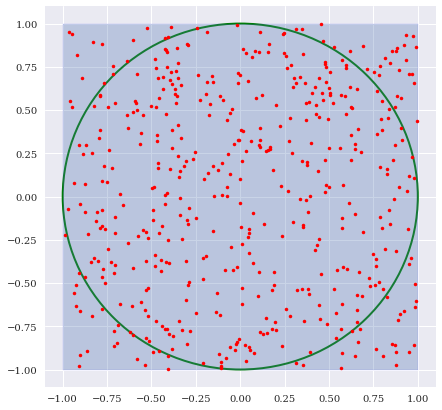

In [14]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
# Draws the unit circle.
circ = plt.Circle((0, 0), radius=1, edgecolor='g', lw=2.0, facecolor='None')
# Draws the square with side length of 2.
box = plt.Rectangle((-1, -1), 2, 2, edgecolor='b', alpha=0.3)
ax.add_patch(circ)
ax.add_patch(box)
# Draws the uniformly distributed random dots.
plt.plot(rn[:, 0], rn[:, 1], 'r.')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)

A `NumPy` implementation of this algorithm is rather concise but also memory-intensive. Total execution time given the parameterization is about one second:

In [15]:
n = int(1e7)

In [16]:
%time rn = np.random.random((n, 2)) * 2 - 1

CPU times: user 99.8 ms, sys: 21.1 ms, total: 121 ms
Wall time: 121 ms


In [17]:
rn.nbytes

160000000

In [24]:
# The distance of the points from the origin (Euclidean norm).
%time distance = (rn ** 2).sum(axis=1)
distance[:8].round(3)

CPU times: user 121 ms, sys: 16 ms, total: 137 ms
Wall time: 138 ms


array([0.126, 1.383, 0.   , 0.141, 1.17 , 0.929, 0.405, 0.225])

In [25]:
# The fraction of those points on the circle relative to all points.
%time frac = (distance <= 1.0).sum() / len(distance)

CPU times: user 6.98 ms, sys: 4.3 ms, total: 11.3 ms
Wall time: 11.5 ms


In [26]:
# This accounts for the square area of 4 for the estimation of the circle area and therewith of π.
pi_mcs = frac * 4
pi_mcs

3.1415808

`mcs_pi_py()` is a Python function using a for loop and implementing the MonteCarlo simulation in a memoryefficient manner. Note that the random numbers are not scaled in this case. The execution time is longer than with the `NumPy` version, but the `Numba` version is faster than `NumPy` in this case:

In [31]:
def mcs_pi_py(n):
    circle = 0
    for _ in range(n):
        x,y = random.random(), random.random()
        if x ** 2 + y ** 2 <= 1:
            circle += 1
    return 4 * circle / n

In [32]:
%time mcs_pi_py(n)

CPU times: user 2.47 s, sys: 0 ns, total: 2.47 s
Wall time: 2.46 s


3.1417212

In [35]:
mcs_pi_nb = numba.jit(mcs_pi_py)

In [36]:
%time mcs_pi_nb(n)

CPU times: user 269 ms, sys: 8.02 ms, total: 277 ms
Wall time: 313 ms


3.1411552

In [37]:
%time mcs_pi_nb(n)

CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 105 ms


3.1418632

A plain `Cython` version with static type declarations only does not perform that much faster than the Python version. However, relying again on the random number generation capabilities of C further speeds up the calculation considerably:

In [47]:
%%cython -a
import random
def mcs_pi_cy1(int n):
    cdef int i, circle = 0
    cdef float x, y
    for i in range(n):
        x, y = random.random(), random.random()
        if x ** 2 + y ** 2 <= 1:
            circle += 1
    return (4 * circle) / n

In [48]:
%time mcs_pi_cy1(n)

CPU times: user 536 ms, sys: 0 ns, total: 536 ms
Wall time: 535 ms


3.1426776

In [49]:
%%cython -a
from libc.stdlib cimport rand
cdef extern from 'limits.h':
    int INT_MAX
def mcs_pi_cy2(int n):
    cdef int i, circle = 0
    cdef float x, y
    for i in range(n):
        x, y = rand() / INT_MAX, rand() / INT_MAX
        if x ** 2 + y ** 2 <= 1:
            circle += 1
    return (4 * circle) / n

In [50]:
%time mcs_pi_cy2(n)

CPU times: user 241 ms, sys: 0 ns, total: 241 ms
Wall time: 241 ms


3.1412076

# Binomial Trees

A popular numerical method to value options is the binomial option pricing model pioneered by Cox, Ross, and Rubinstein (1979). This method relies on representing the possible future evolution of an asset by a (recombining) tree. In this model, as in the Black-Scholes-Merton (1973) setup, there is a *risky asset*, an index or stock, and a *riskless asset*, a bond. The relevant time interval from today until the maturity of the option is divided in general into equidistant subintervals of length $\Delta t$. Given an index level at time $s$ of $S_s$, the index level at $t = s + \Delta t$ is given by $S_t = S_s \cdot m$, where $m$ is chosen randomly from $\{u,d\}$ with $0 < d < e^{r\Delta t} < u = e^{\sigma\sqrt{\Delta t}}$ as well as $u = \frac{1}{d}$. $r$ is the constant, riskless short rate.

## Python

The code that follows presents a Python implementation that creates a recombining tree based on some fixed numerical parameters for the model:

In [4]:
import math

In [10]:
S0 = 36.    # Initial value of the risky asset.
T = 1.0    # Time horizon for the binomial tree simulation.
r = 0.06    # Constant short rate.
sigma = 0.2    # Constant volatility factor.

In [3]:
def simulate_tree(M):
    dt = T / M    # Length of the time intervals.
    u = math.exp(sigma * math.sqrt(dt))    # Factors for the upward and downward movements.
    d = 1 / u
    S = np.zeros((M + 1, M + 1))
    S[0, 0] = S0
    z = 1
    for t in range(1, M + 1):
        for i in range(z):
            S[i, t] = S[i, t - 1] * u
            S[i + 1, t] = S[i, t-1] * d
        z += 1
    return S

Contrary to what happens in typical tree plots, an upward movement is represented in the `ndarray` object as a sideways movement, which decreases the `ndarray` size considerably:

In [6]:
np.set_printoptions(formatter={'float': lambda x: '%6.2f' % x})

In [7]:
simulate_tree(4)    # Tree with 4 time intervals.

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [8]:
%time simulate_tree(500)    # Tree with 500 time intervals.

CPU times: user 73.6 ms, sys: 0 ns, total: 73.6 ms
Wall time: 72.7 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

## NumPy

With some trickery, such a binomial tree can be created with `NumPy` based on fully vectorized code:

In [9]:
M = 4

In [10]:
up = np.arange(M + 1)
# ndarray object with gross upward movements.
up = np.resize(up, (M + 1, M + 1))
up

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [12]:
# ndarray object with gross downward movements.
down = up.T * 2
down

array([[0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2],
       [4, 4, 4, 4, 4],
       [6, 6, 6, 6, 6],
       [8, 8, 8, 8, 8]])

In [13]:
# ndarray object with net upward (positive) and downward (negative) movements.
up - down

array([[ 0,  1,  2,  3,  4],
       [-2, -1,  0,  1,  2],
       [-4, -3, -2, -1,  0],
       [-6, -5, -4, -3, -2],
       [-8, -7, -6, -5, -4]])

In [14]:
dt = T / M

In [15]:
# Tree for four time intervals (upper-right triangle of values).
S0 * np.exp(sigma * math.sqrt(dt) * (up - down))

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [ 29.47,  32.57,  36.00,  39.79,  43.97],
       [ 24.13,  26.67,  29.47,  32.57,  36.00],
       [ 19.76,  21.84,  24.13,  26.67,  29.47],
       [ 16.18,  17.88,  19.76,  21.84,  24.13]])

In the `NumPy` case, the code is a bit more compact. However, more importantly, `NumPy` vectorization achieves a speedup of an order of magnitude while not using more memory:

In [16]:
def simulate_tree_np(M):
    dt = T / M
    up = np.arange(M + 1)
    up = np.resize(up, (M + 1, M + 1))
    down = up.transpose() * 2
    S = S0 * np.exp(sigma * math.sqrt(dt) * (up - down))
    return S

In [17]:
simulate_tree_np(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [ 29.47,  32.57,  36.00,  39.79,  43.97],
       [ 24.13,  26.67,  29.47,  32.57,  36.00],
       [ 19.76,  21.84,  24.13,  26.67,  29.47],
       [ 16.18,  17.88,  19.76,  21.84,  24.13]])

In [18]:
%time simulate_tree_np(500)

CPU times: user 0 ns, sys: 5.8 ms, total: 5.8 ms
Wall time: 5.45 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [ 35.36,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [ 34.73,  35.05,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.41,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.40,   0.41,   0.41]])

## Numba

This financial algorithm should be well suited to optimization through `Numba` dynamic compilation. And indeed, another speedup compared to the `NumPy` version of an order of magnitude is observed. This makes the `Numba` version orders of magnitude faster than the Python (or rather hybrid) version:

In [21]:
simulate_tree_nb = numba.jit(simulate_tree)

In [22]:
simulate_tree_nb(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [23]:
%time simulate_tree_nb(500)

CPU times: user 615 µs, sys: 0 ns, total: 615 µs
Wall time: 618 µs


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

In [24]:
%timeit simulate_tree_nb(500)

115 µs ± 684 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Cython

As before, `Cython` requires more adjustments to the code to see significant improvements. The following version uses mainly static type declarations and certain imports that improve the performance compared to the regular Python imports and functions, respectively:

In [8]:
%%cython -a
import numpy as np
cimport cython
from libc.math cimport exp, sqrt
cdef float S0 = 36.
cdef float T = 1.0
cdef float r = 0.06
cdef float sigma = 0.2
def simulate_tree_cy(int M):
    cdef int z, t, i
    cdef float dt, u, d
    # Declaring the ndarray object to be a C array is critical for performance.
    cdef float[:, :] S = np.zeros((M + 1, M + 1), dtype=np.float32)
    dt = T / M
    u = exp(sigma * sqrt(dt))
    d = 1 / u
    S[0, 0] = S0
    z = 1
    for t in range(1, M + 1):
        for i in range(z):
            S[i, t] = S[i, t-1] * u
            S[i+1, t] = S[i, t-1] * d
        z += 1
    return np.array(S)

The `Cython` version shaves off another 30% of the execution time compared to the `Numba` version:

In [4]:
simulate_tree_cy(4)

array([[36.      , 39.786156, 43.970505, 48.594925, 53.7057  ],
       [ 0.      , 32.574146, 36.      , 39.786156, 43.970505],
       [ 0.      ,  0.      , 29.474304, 32.574146, 36.      ],
       [ 0.      ,  0.      ,  0.      , 26.669453, 29.474304],
       [ 0.      ,  0.      ,  0.      ,  0.      , 24.131517]],
      dtype=float32)

In [5]:
%time simulate_tree_cy(500)

CPU times: user 1.3 ms, sys: 75 µs, total: 1.37 ms
Wall time: 864 µs


array([[3.6000000e+01, 3.6323441e+01, 3.6649788e+01, ..., 3.0957734e+03,
        3.1235872e+03, 3.1516509e+03],
       [0.0000000e+00, 3.5679440e+01, 3.6000000e+01, ..., 3.0408865e+03,
        3.0682073e+03, 3.0957734e+03],
       [0.0000000e+00, 0.0000000e+00, 3.5361732e+01, ..., 2.9869729e+03,
        3.0138091e+03, 3.0408865e+03],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.1863266e-01,
        4.2239383e-01, 4.2618880e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        4.1490495e-01, 4.1863266e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 4.1121045e-01]], dtype=float32)

In [6]:
%timeit S = simulate_tree_cy(500)

150 µs ± 538 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Monte Carlo Simulation

Monte Carlo simulation is an indispensible numerical tool in computational finance. It has been in use since long before the advent of modern computers. Banks and other financial institutions use it, among others, for pricing and risk management purposes. As a numerical method it is perhaps the most flexible and powerful one in finance. However, it often also is the most computationally demanding one. That is why Python was long dismissed as a proper programming language to implement algorithms based on Monte Carlo simulation — at least for real-world application scenarios.

This section analyzes the Monte Carlo simulation of the geometric Brownian motion, a simple yet still widely used stochastic process to model the evolution of stock prices or index levels. Among others, the Black-Scholes-Merton (1973) theory of option pricing draws on this process. In their setup the underlying of the option to be valued follows the stochastic differential equation (SDE), as seen in Equation \ref{sde}. $S_t$ is the value of the underlying at time $t$; $r$ is the constant, riskless short rate; $\sigma$ is the constant instantaneous volatility; and $Z_t$ is a Brownian motion.

\begin{equation}
dS_t = rS_t dt + \sigma S_t dZ_t \label{sde}
\end{equation}

This SDE can be discretized over equidistant time intervals and simulated according to Equation $\ref{euler}$, which represents an Euler scheme. In this case, $z$ is a standard normally distributed random number. For $M$ time intervals, the length of the time intervals is given as $\Delta t\equiv \frac{T}{M}$ where $T$ is the time horizon for the simulation (for example, the maturity date of an option to be valued).

\begin{equation}
S_t = S_{t - \Delta t} \exp ((r - \frac{\sigma^2}{2} \Delta t + \sigma \sqrt{\Delta t} z) \label{euler}
\end{equation}

The Monte Carlo estimator for a European call option is the given by Equation \ref{european}, where $S_T(i)$ is the $i$th simulated value of the underlying at maturity $T$ for a total number of simulated paths $I$ with $i = 1,2,...I$.

\begin{equation}
C_0 = e^{-rT} \frac{1}{I} \Sigma_I \max (S_T(i) - K, 0) \label{european}
\end{equation}

## Python

First, a Python -- or rather a hybrid -- version, `mcs_simulation_py()`, that implements the Monte Carlo simulation according to Equation \ref{euler}. It is hybrid since it implements Python loops on `ndarray` objects. As seen previously, this might make for a good basis to dynamically compile the code with `Numba`. As before, the execution time sets the benchmark. Based on the simulation, a European put option is valued:

In [15]:
# The number of time intervals for discretization. 
M = 100
# The number of paths to be simulated. 
I = 50000

In [19]:
def mcs_simulation_py(p):
    M, I = p
    dt = T / M
    S = np.zeros((M+1, I))
    S[0] = S0
    # The random numbers, drawn in a single vectorized step.
    rn = np.random.standard_normal(S.shape)
    # The nested loop implementing the simulation based on the Euler scheme.
    for t in range(1, M+1):
        for i in range(I):
            S[t, i] = S[t-1, i] * math.exp((r-sigma**2/2)*dt +
                                          sigma * math.sqrt(dt) * rn[t, i])
    return S

In [26]:
%time S = mcs_simulation_py((M, I))

CPU times: user 3.75 s, sys: 0 ns, total: 3.75 s
Wall time: 3.75 s


In [27]:
# The mean end-of-period value based on the simulation. 
S[-1] . mean()

38.215058313073364

In [22]:
# The theoretically expected end-of-period value. 
S0 * math.exp(r*T)

38.22611567563295

In [23]:
# The strike price of the European put option. 
K = 40

In [29]:
# The Monte Carlo estimator for the option. 
C0 = math.exp(-r * T) * np.maximum(K - S[-1], 0).mean()

In [30]:
C0

3.8514647024229998

## Numpy

The `Numpy` version, `mcs_simulation_np()`, is not too different. It still has one Python loop, namely over the time intervals. The other dimension is handled by vectorized code over all paths. It is about 20 times faster than the first version:

In [31]:
def mcs_simulation_np(p):
    M, I = p
    dt = T / M
    S = np.zeros((M+1, I))
    S[0] = S0
    rn = np.random.standard_normal(S.shape)
    for t in range(1, M+1):    # The loop over the time intervals. 
        # The Euler scheme with vectorized NumPy code handling all paths at once.
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * math.sqrt(dt) * rn[t])
    return S

In [32]:
%time S = mcs_simulation_np((M,I))

CPU times: user 108 ms, sys: 25.1 ms, total: 133 ms
Wall time: 133 ms


In [33]:
S[-1].mean()

38.31022407078316

In [37]:
%timeit S = mcs_simulation_np((M, I))

124 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Numba

It should not come as a surprise anymore that `Numba` is applied to such an algorithm type easily, and with significant performance improvements. The `Numba` version, `mcs_simulation_nb`, is slightly faster than the `NumPy` version:

In [38]:
mcs_simulation_nb = numba.jit(mcs_simulation_py)

In [39]:
%time S = mcs_simulation_nb((M,I))    # First call with compile-time overhead. 

CPU times: user 427 ms, sys: 24.5 ms, total: 452 ms
Wall time: 491 ms


In [40]:
# Second call without that overhead.
%time S = mcs_simulation_nb((M,I))

CPU times: user 139 ms, sys: 24.2 ms, total: 163 ms
Wall time: 163 ms


In [41]:
S[-1].mean()

38.261227803051554

In [42]:
C0 = math.exp(-r * T) * np.maximum(K - S[-1], 0).mean()

In [43]:
C0

3.8407741284351786

In [44]:
%timeit S = mcs_simulation_nb((M,I))

159 ms ± 950 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Cython

With `Cython`, again not surprisingly, the effort required to speed up the code is higher. However, the speedup itself is not greater. The `Cython` version, `mcs_simulation_cy( )`, seems to be even a bit slower compared to the `NumPy` and `Numba` versions. Among other factors, some time is needed to transform the simulation results to an `ndarray` object: 

In [14]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
from libc. math cimport exp, sqrt
cdef float S0 = 36.
cdef float T = 1.0
cdef float r = .06
cdef float sigma = 0.2
@cython.boundscheck(False)
@cython.wraparound(False)
def mcs_simulation_cy(p):
    cdef int M, I
    M, I = p
    cdef int t, i
    cdef float dt = T / M
    cdef double[:, :] S = np.zeros((M + 1, I))
    cdef double[:, : ] rn = np.random.standard_normal((M + 1, I))
    S[0] = S0
    for t in range(1, M + 1):
        for i in range(I):
            S[t, i] = S[t-1, i] * exp((r-sigma**2/2)*dt +
                                          sigma * sqrt(dt) * rn[t, i])
    return np.array(S) 

UsageError: Cell magic `%%cython` not found.


In [50]:
%time S = mcs_simulation_cy((M,I))

CPU times: user 124 ms, sys: 7.94 ms, total: 132 ms
Wall time: 131 ms


In [51]:
S[-1].mean()

38.26112292333337

In [52]:
%timeit S = mcs_simulation_cy((M,I))

126 ms ± 732 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Multiprocessing 

Monte Carlo simulation is a task that lends itself well to parallelization. One approach would be to parallelize the simulation of 100,000 paths, say, into 10 processes simulating 10,000 paths each. Another would be to parallelize the simulation of the 100,000 paths into multiple processes, each simulating a different financial instrument, for example. The former case -- namely, the parallel simulation of a larger number of paths based on a fixed number of separate processes -- is illustrated in what follows. 

The following code again makes use of the multiprocessing module. It divides the total number of paths to be simulated $I$ into smaller chunks of size $\frac{I}{P}$ with $p > 0$. After all the single tasks are finished, the results are put together in a single `ndarray` object via `np.hstack()`. This approach can be applied to any of the versions presented previously. For the particular parameterization chosen here, there is no speedup to be observed through this parallelization approach: 

In [53]:
import multiprocessing as mp

In [54]:
# The Pool object for parallelization. 
pool = mp.Pool(processes=4)

In [55]:
# The number of chunks into which the simulation is divided.
p = 20

In [57]:
%timeit S = np.hstack(pool.map(mcs_simulation_np, p*[(M, int(I/p))]))

61.8 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
%timeit S = np.hstack(pool.map(mcs_simulation_nb, p*[(M, int(I/p))]))

67.1 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
%timeit S = np.hstack(pool.map(mcs_simulation_cy, p*[(M, int(I/p))]))

58.9 ms ± 661 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Recursive pandas Algorithm

This section addresses a somewhat special topic which is, however, an important one in financial analytics: the implementation of recursive functions on financial time series data stored in a pandas `DataFrame` object. While `pandas` allows for sophisticated vectorized operations on `DataFrame` objects, certain recursive algorithms are hard or impossible to vectorize, leaving the financial analyst with slowly executed Python loops on `DataFrame` objects. The examples that follow implement what is called the `exponentially weighted moving average` (EWMA) in a simple form. 

The EWMA for a financial time series $S_t$, $t \in \{0,\dots,T\}$, is given by Equation \ref{ewma}.

\begin{equation}
\begin{aligned}
EWMA_0 &= S_0 \\
EWMA_t &= \alpha \cdot S_t + (1-\alpha) \cdot EWMA_{t-1}, t \in \{1, \dots, T\}
\end{aligned}
\label{ewma}
\end{equation}

Although simple in nature and straightforward to implement, such an algorithm might lead to rather slow code.

## Python

Consider first the Python version that iterates over the `DatetimeIndex` of a `DataFrame` object containing financial time series data for a single financial instrument (see Chapter 8). 

In [1]:
import pandas as pd

In [2]:
sym = 'SPY'

In [3]:
data = pd. DataFrame(pd.read_csv('tr_eikon_eod_data.csv',
                                index_col=0, parse_dates=True)[sym]).dropna()

In [4]:
alpha = 0.25

In [5]:
data['EWMA'] = data[sym]    # Initializes the EWMA column. 

In [8]:
%%time
# Implements the algorithm based on a Python loop. 
for t in zip(data.index, data.index[1:]):
    data.loc[t[1], 'EWMA'] = (alpha * data.loc[t[1], sym] +
                              (1-alpha) * data.loc[t[0], 'EWMA'])

CPU times: user 403 ms, sys: 18.1 ms, total: 421 ms
Wall time: 364 ms


In [9]:
data.head()

,SPY,EWMA
Date,,
2010-01-04,113.33,113.330000
2010-01-05,113.63,113.405000
2010-01-06,113.71,113.481250
2010-01-07,114.19,113.658438
2010-01-08,114.57,113.886328


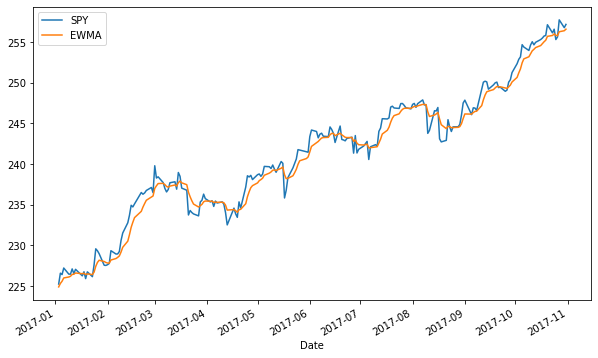

In [11]:
data[data.index > '20170101'].plot(figsize=(10, 6));

Now consider more general Python function `ewma_py()`. It can be applied directly on the column or the raw financial times series data in the form of an `ndarray` object:

In [12]:
def ewma_py(x, alpha):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1-alpha) * y[i-1]
    return y

In [21]:
# Applies the function to the series object directly (i.e., the column). 
%time data['EWMA_PY'] = ewma_py(data[sym], alpha)

CPU times: user 26.9 ms, sys: 0 ns, total: 26.9 ms
Wall time: 26.3 ms


In [23]:
type(ewma_py(data[sym], alpha))

numpy.ndarray

In [24]:
# Applies the function to the ndarray object containing the raw data.
%time data['EWMA_PY'] = ewma_py(data[sym].values, alpha)

CPU times: user 1.02 ms, sys: 109 µs, total: 1.13 ms
Wall time: 1.06 ms


This approach already speeds up the code execution considerably -- by a factor of from about 20 to more than 100.

## Numba 

The very structure of this algorithm promises further speedups when applying `Numba`. And indeed, when the function `ewma_nb()` is applied to the `ndarray` version of the data, the speedup is again by an order of magnitude: 

In [37]:
ewma_nb = numba.jit(ewma_py)

In [38]:
# Applies the function to the series object directly (i.e., the column). 
%time data['EWMA_NB'] = ewma_nb(data[sym], alpha)

<ipython-input-12-34b9530cd905>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "ewma_py" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-12-34b9530cd905> (2)

File "<ipython-input-12-34b9530cd905>", line 2:
def ewma_py(x, alpha):
    y = np.zeros_like(x)
    ^

  def ewma_py(x, alpha):
<ipython-input-12-34b9530cd905>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "ewma_py" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-12-34b9530cd905>", line 4:
def ewma_py(x, alpha):
    <source elided>
    y[0] = x[0]
    for i in range(1, len(x)):
    ^

  def ewma_py(x, alpha):
/home/jay/miniconda3/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "ewma_py" was compiled in object mode without forceobj=True, but has lifted l

CPU times: user 256 ms, sys: 0 ns, total: 256 ms
Wall time: 255 ms


In [39]:
# Applies the function to the series object directly (i.e., the column). 
%timeit data['EWMA_NB'] = ewma_nb(data[sym], alpha)

24.6 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
# Applies the function to the ndarray object containing the raw data.
%time data['EWMA_NB'] = ewma_nb(data[sym].values, alpha)

CPU times: user 84.2 ms, sys: 0 ns, total: 84.2 ms
Wall time: 82.9 ms


In [41]:
%timeit data['EWMA_NB'] = ewma_nb(data[sym].values, alpha)

61.1 µs ± 282 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Cython

The `Cython` version, `ewma_cy()`, also achieves considerable speed improvements but it is not as fast as the `Numba` version in this case: 

In [42]:
%%cython
import numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def ewma_cy(double[:] x, float alpha):
    cdef int i
    cdef double[:] y = np.empty_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1-alpha) * y[i-1]
    return y

In [43]:
%time data['EWMA_CY'] = ewma_cy(data[sym].values, alpha) 

CPU times: user 2.45 ms, sys: 52 µs, total: 2.5 ms
Wall time: 2.34 ms


In [44]:
%timeit data['EWMA_CY'] = ewma_cy(data[sym].values, alpha) 

311 µs ± 4.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This final example illustrates again that there are in general multiple options to implement (nonstandard) algorithms. All options might lead to exactly the same results, while also showing considerably different performance characteristics. The execution times in this example range from 0.1 ms to 500 ms a factor of 5,000 times.

# Conclusion

The Python ecosystem provides a number of ways to improve the performance of code:

*Idioms and paradigms*

Some Python paradigms and idioms might be more performant than others, given a specific problem; in many cases, for instance, vectorization is a paradigm that not only leads to more concise code but also to higher speeds (sometimes at the cost of a larger memory footprint). 

*Packages*

There are a wealth of packages available for different types of problems, and using a package adapted to the problem can often lead to much higher performance; good examples are NumPy with the ndarray class and pandas with the DataFrame class. 

*Compiling*

Powerful packages for speeding up financial algorithms are `Numba` and `Cython` for the dynamic and static compilation of Python code. 

*Parallelization*

Some Python packages, such as `multiprocessing`, allow for the easy parallelization of Python code; the examples in this chapter only use parallelization on a single machine but the Python ecosystem also offers technologies for multi-machine (cluster) parallelization. 

A major benefit of the performance approaches presented in this chapter is that they are in general easily implementable, meaning that the additional effort required is regularly low. In other words, performance improvements often are low-hanging fruit given the performance packages available as of today.